# Programming Quantum Computers
- #### Hands-on Experiential Learning <font color="red">for the Software Engineer</font>

# Chapter Ch05_04
# <font color="red">Hands-on</font>:  <font color="blue">Quantum Conditional Execution</font> 

## <font color="red">if</font> a < 0 <font color="red">then</font> b += 1
> - ###  Conditionally execute large pieces of digital logic in superposition.

![QC_Programming-red](img/QC_Programming-red.png "QC_Programming-red")

<BR>
    
<font color="red">**Notice**</font>: All materials herein were <font color="red">**curated**</font> by **Matthew R. Versaggi (profversaggi@gmail.com)** and are released into the open source to foster growth and welfare of expanding the Quantum Computing domain - the only obligation one incurs when using, copying, distributing or referencing this is to kindly reference the author and send me an email so I know how useful the material is to you.

<font color="red">**Notice**</font>: Python Code contributions for the Circle Plots are the work of **David Radcliffe**.

## Pedagogical Approach: (<font color="red">**Read this first !**</font>)

This material is intended to educate **software engineers** in certain aspects of Quantum Computing, therefore its focus will be on conveying the conceptual ideas in a form digestible to them, and supporting it with exercises to reinforce those concepts. 

Because of that pedagogical approach, **this material won't lead with or heavily leverage the concepts and language indigenous to physics and math**, but only in those terms most easily digestible to the modern software engineer.

This Jupyter Notebook is <font color="red">**not intended as a stand alone educational vehicle**</font>  - it's meant to be accompanied by a decicated power point deck that contains the main concepts to be presented by an instructor - **it is intended as a vehicle for a hands on workshop environment to facilitate learning through a guided experience.**

> **Note:-** Because of the above educational approach:
1. There is a certain amount of basic Quantum Computing knowledge that is assumed.
2. An active internet connection is **always** assumed.
3. Online references/links will be provided where appropriate
4. References to books will be made where appropriate
5. Much of this material is **dense and detailed**, the reader is <font color="red">**cautioned**</font> to be careful and slow to digest the *nuances* of the material.

## What you will be exposed to - High level: 

- Software engineers in the Quantum Computing space need to **<font color="blue">gain a mastery of the simulation frameworks and tools used to understand and solve problems quantumly</font>**. Under the hood, the **<font color="red">simulators mathematically represent the "Ideal" manifestations of quantum hardware</font>** that (theoretically) the "Actual" quantum hardware would behave exactly like. For the software engineer, this is the preferred situation as it permits them to understand and solve problems w/out being bound to the limitations of the hardware as it matures.


- Given the above, there are a host of technical concepts that need to be **<font color="red">understood experientially</font>** - we'll intentionally employ a vendor / framework agnostic approach to focus on the delivery of concept understanding and intuition procurement as the main value-add.


## Accompanying Text:

<BR>

<a href="https://www.amazon.com/Programming-Quantum-Computers-Essential-Algorithms/dp/1492039683" target="_blank"><img src="img/OreillyBookImage-small.png" height="250" align=left style="padding:15px;"></a>


> The core materials leveraged in this Jupyter Notebook comes from the following book, and is required reading to engage in the problem sets covered.

> The problem sets contained here will be expanded versions of the exercises contained in the book for sake of gaining intuition about the particular concept in question through leveraging various 'other' frameworks, tools, and instruments indigenous to the quantum programming space. 


> The core idea is that the various "simulators" circuitry (underlying mathematical representations) is considered the "Ideal" at the time of this JNB's construction, and therefore are the bect tools we have to address the problems we are interested in. To avoid being constrained by any particular framework, tool set, and software instruments, the idea is to leverage a host of appropriate "tools" when addressing any particular concept, problem or issue to remaind technology agnostic, but concept and intuition rich.


- **Note:** The problems explored are organized and ordered according to chapter.

<BR>

**<font color="red" size=4>Notice</font>:** - Prior to embarking on this notebook the reader is **highly encouraged to procure a <font color="red" size=4>reasonable</font> <font color="blue" size=4>introduction</font>** to the following key programming (and circuit) frameworks used:

0. <a href="https://oreilly-qc.github.io/" target="_blank"><font color="blue" size=4>QCEngine</font></a>
0. <a href="https://qiskit.org/textbook/preface.html" target="_blank"><font color="blue" size=4>Qiskit Tutorial</font></a>, <a href="https://qiskit.org/" target="_blank"><font color="blue" size=4>Qiskit Home</font></a>
0. <a href="https://algassert.com/quirk" target="_blank"><font color="blue">QUIRK</font></a>

# <font color="red">Example Problem(s):</font> 

**This example problem is archetypal** of how the exercises highlighted in the book can be expanded to include a host of other tools that help build understanding and intuition of the concepts being explored. 

- The <font color="blue">QCEngine</font> is a staple, but the <font color="blue">Bloch Sphere Playground Application</font>, the <font color="blue">Quantum Gate Playground</font>, <font color="blue">QUIRK</font>, and <font color="blue">Qiskit</font> are also instructive to leverage when persuing intuition about the concept and will be often used.

# Quantum Conditional Execution

![Conditional Execution](img/conditional_execution.png "Conditional Execution")

<BR>
    
![Conditional Execution](img/ConditionalExecution.png "Conditional Execution")

<BR>


![Conditional Execution](img/ConditionalExecution-StateSpace.png "Conditional Execution")

### Reminder: 8-bit Binary Table
<BR>
    
![binary-table_0-15-NEW](img/binary-table_0-15-NEW.png "binary-table_0-15-NEW")

#### <font color="blue">Circuit Implementation</font> - the below example implements the above circuit.
- **Copy and Run** the code base below and step through the circuit to gain intuition about its behavior.
- **Observe** the code that implements the QCEngine **<font color="red">if a < 0 then b += 1</font>** - **this is important to understand**..

> - Peruse the binary value of the various registers during the circuit flow - make sure you understand what's happening.

> ### <font color="red">Full Screen Mode</font>:

> - https://oreilly-qc.github.io?p=5-4

> ### <font color="red">Full Screen Mode</font>:

> - https://oreilly-qc.github.io?p=5-4

# <font color="blue">QCEngine</font>

In [1]:
from IPython.display import IFrame
IFrame(src='https://oreilly-qc.github.io?p=5-4', width=900, height=900)

# <font color="blue">Qiskit</font> Run #1

- Execute the below circuit multiple times in Qiskit and note the differences, similarities, and behaviors.
- **The first run** will **not** execute any of the **<font color="red">conditional</font>** operators, but will show the unaltered values of each q_register.
- **The second run** will execute the **<font color="red">conditional</font>** Operators but due to the qubits in superposition, it likely won't match the previous run - this is due to Qiskit being designed to run on actual quantum hardware. Once can only inspect intermediate results in a simulator.

<BR>
**REMINDER - Nuanced return values**: Qiskit and MSB's vs LSB's (Continuous circuits are straight forward - but must be reversed. Multiple registers on the other hand can create confusion, and the individual ones must be reversed as well, plus the registers are in LIFO order)
    
- **The qubits must be measured** to return an intelligible overall value for the **<font color="red">conditional</font>** Operators. 
    
> **NOTE**: QuantumCircuit(q, v) means "add q, then add v" (v is more significant, and the left tensor). 
    
**R&D on Qiskit's ordering of curcuit return values**:     
- https://quantumcomputing.stackexchange.com/questions/8893/why-is-the-order-reversed-on-measurement
- https://github.com/Qiskit/qiskit-terra/issues/1148
    
    
    

### <font color="blue">Run this entire function multiple times and observe the variant outputs after each iteration.</font>
- a sample run is below, however, the **operators have been disabled** so you can observe the value of the registers post each preparation phase.

<BR>

   
![Conditional Execution](img/ConditionalExecution.png "Conditional Execution")



### Reminder: 8-bit Binary Table
<BR>
    
![binary-table_0-15-NEW](img/binary-table_0-15-NEW.png "binary-table_0-15-NEW")



                 Binary Positions:  4 2 1
                                    -----
Classical Register-A Measurements:  1 0 1


                 Binary Positions:  4 2 1
                                    ----
Classical Register-B Measurements:  0 1 1




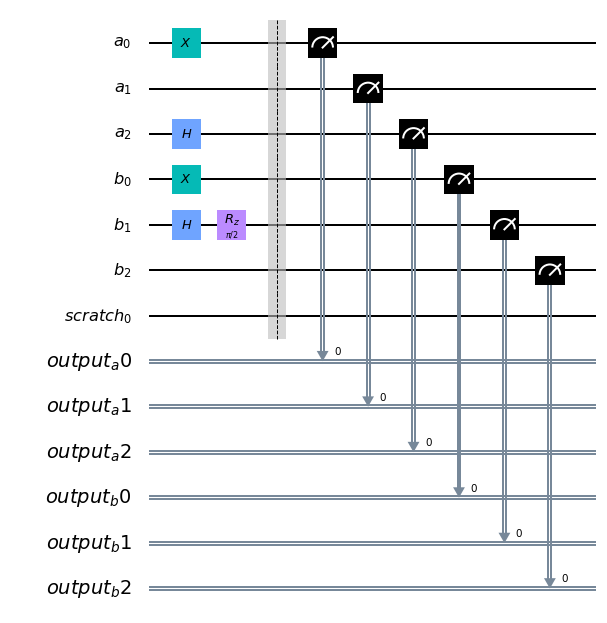

In [15]:
## Programming Quantum Computers
##   by Eric Johnston, Nic Harrigan and Mercedes Gimeno-Segovia
##   O'Reilly Media
##
## More samples like this can be found at http://oreilly-qc.github.io
##
## A complete notebook of all Chapter 5 samples (including this one) can be found at
##  https://github.com/oreilly-qc/oreilly-qc.github.io/tree/master/samples/Qiskit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, BasicAer
import math
## Uncomment the next line to see diagrams when running in a notebook
#%matplotlib inline

## Example 5-4: Quantum conditional execution

## Note that this looks different from the gates in the book, because
## we're building the operations from Toffoli gates

# Set up the program
a = QuantumRegister(3, name='a')
b = QuantumRegister(3, name='b')
scratch = QuantumRegister(1, name='scratch')

# Setup SIX Classical Registers
output_a0 = ClassicalRegister(1, name='output_a0')
output_a1 = ClassicalRegister(1, name='output_a1')
output_a2 = ClassicalRegister(1, name='output_a2')
output_b0 = ClassicalRegister(1, name='output_b0')
output_b1 = ClassicalRegister(1, name='output_b1')
output_b2 = ClassicalRegister(1, name='output_b2')

# qc = QuantumCircuit(a, b, scratch)
qc = QuantumCircuit(a, b, scratch, output_a0, output_a1, output_a2, output_b0, output_b1, output_b2)


def main():
    ## initialization
    qc.x(a[0])
    qc.h(a[2])
    qc.x(b[0])
    qc.h(b[1])
    qc.rz(math.radians(90), b[1])
    qc.barrier()
    
    ## Increment - This are disabled and will be executed in the next section / iteration.
    #
    # add_int(a, -3)
    # qc.barrier()
    # add_int(b, 1, [a[2]])
    # qc.barrier()
    # add_int(a, 3)

    
    
###############################################
## Some utility functions

def add_squared_qint(qdest, rhs, condition_qubits=None):
    if condition_qubits is None:
        condition_qubits = []
    for bit in range(len(rhs)):
        slideMask = list(set(condition_qubits + [rhs[bit]]))
        add_qint(qdest, rhs, slideMask, bit);

def add_qint(qdest, rhs, condition_qubits=None, shiftRHS=0):
    if condition_qubits is None:
        condition_qubits = []
    for bit in range(len(rhs)):
        add_int(qdest, 1 << bit, list(set([rhs[bit]] + condition_qubits)), shiftRHS)

def add_int(qdest, rhs, condition_qubits=None, shiftRHS=0):
    if condition_qubits is None:
        condition_qubits = []
    reverse_to_subtract = False
    if rhs == 0:
        return
    elif rhs < 0:
        rhs = -rhs
        reverse_to_subtract = True
    rhs <<= shiftRHS
    ops = []
    add_val = int(rhs)
    condition_mask = (1 << len(qdest)) - 1

    add_val_mask = 1
    while add_val_mask <= add_val:
        cmask = condition_mask & ~(add_val_mask - 1)
        if add_val_mask & add_val:
            add_shift_mask = 1 << (len(qdest) - 1)
            while add_shift_mask >= add_val_mask:
                cmask &= ~add_shift_mask
                ops.append((add_shift_mask, cmask))
                add_shift_mask >>= 1
        condition_mask &= ~add_val_mask
        add_val_mask <<= 1
    if reverse_to_subtract:
        ops.reverse()
    for inst in ops:
        op_qubits = [x for x in condition_qubits]
        mask = 1
        for i in range(len(qdest)):
            if inst[1] & (1 << i):
                op_qubits.append(qdest[i])
        for i in range(len(qdest)):
            if inst[0] & (1 << i):
                op_qubits.append(qdest[i])
        multi_cx(op_qubits)

def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])

        
# Execute the main function        
main()


# Measure the Qubits from quantum register 'a' into classical registers (0-2)
qc.measure(a[0], output_a0)
qc.measure(a[1], output_a1)
qc.measure(a[2], output_a2)

# Measure the Qubits from quantum register 'b' into classical registers (0-2)
qc.measure(b[0], output_b0)
qc.measure(b[1], output_b1)
qc.measure(b[2], output_b2)


## That's the program. Everything below runs and draws it.

backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

outputstate = result.get_statevector(qc, decimals=3)

# Fetch the counts and print out the classical measurements in order (l->R) of each q-register (a & b)       
# These counts are in reverse order as a whole and must be corrected.
counts = result.get_counts(qc)


# Rearrange the counts in the order we need them
for k in counts:
    binary_number = ''.join(reversed(k))       
  

# 
# Debug
# print("Binary Number: ", binary_number)    
    
    
# Set up the binary numbers of each c-register (a & b) - reversing each individual register using
# the slice technique '[::-1]'.        
c_register_a = binary_number[0 : 5][::-1]
c_register_b = binary_number[6 : 11][::-1] 
    
    
# Printing classical register values for intuitions sake    
print("\n")  
print("                 Binary Positions:  4 2 1")    
print("                                    -----") 
print("Classical Register-A Measurements: ", c_register_a)  
print("\n")
print("                 Binary Positions:  4 2 1")    
print("                                    ----") 
print("Classical Register-B Measurements: ", c_register_b)  
print("\n")

qc.draw(output='mpl')        # draw the circuit



# <font color="blue">Qiskit</font> Run # 2

- Execute the same circuit (albit in pieces) multiple times, but this time the **<font color="red">conditional</font>** operator **gets** executed.
- Due to the qubits in superposition, it likely won't match the previous run. 
- Make sure to run the whole circuit each time to avoid run pollution.

- **use this codebase as inspiration for the HW.**


### <font color="blue">Misc Utility Functions</font>
#### <font color="red">NOTE</font>: Disregard the complexity of these helper functions - they can safely be ignored, just run them.

In [19]:
###############################################
## Some utility functions

def add_squared_qint(qdest, rhs, condition_qubits=None):
    if condition_qubits is None:
        condition_qubits = []
    for bit in range(len(rhs)):
        slideMask = list(set(condition_qubits + [rhs[bit]]))
        add_qint(qdest, rhs, slideMask, bit);

def add_qint(qdest, rhs, condition_qubits=None, shiftRHS=0):
    if condition_qubits is None:
        condition_qubits = []
    for bit in range(len(rhs)):
        add_int(qdest, 1 << bit, list(set([rhs[bit]] + condition_qubits)), shiftRHS)

def add_int(qdest, rhs, condition_qubits=None, shiftRHS=0):
    if condition_qubits is None:
        condition_qubits = []
    reverse_to_subtract = False
    if rhs == 0:
        return
    elif rhs < 0:
        rhs = -rhs
        reverse_to_subtract = True
    rhs <<= shiftRHS
    ops = []
    add_val = int(rhs)
    condition_mask = (1 << len(qdest)) - 1

    add_val_mask = 1
    while add_val_mask <= add_val:
        cmask = condition_mask & ~(add_val_mask - 1)
        if add_val_mask & add_val:
            add_shift_mask = 1 << (len(qdest) - 1)
            while add_shift_mask >= add_val_mask:
                cmask &= ~add_shift_mask
                ops.append((add_shift_mask, cmask))
                add_shift_mask >>= 1
        condition_mask &= ~add_val_mask
        add_val_mask <<= 1
    if reverse_to_subtract:
        ops.reverse()
    for inst in ops:
        op_qubits = [x for x in condition_qubits]
        mask = 1
        for i in range(len(qdest)):
            if inst[1] & (1 << i):
                op_qubits.append(qdest[i])
        for i in range(len(qdest)):
            if inst[0] & (1 << i):
                op_qubits.append(qdest[i])
        multi_cx(op_qubits)

def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])


### <font color="blue">Setup and Q_Circuit Design</font>

In [20]:
## Example 5-4: Quantum conditional execution

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ, BasicAer
import math

## Uncomment the next line to see diagrams when running in a notebook
%matplotlib inline

## Note that this looks different from the gates in the book, because
## we're building the operations from Toffoli gates

# Set up the program
a = QuantumRegister(3, name='a')
b = QuantumRegister(3, name='b')
scratch = QuantumRegister(1, name='scratch')


# Setup SIX Classical Registers
output_a0 = ClassicalRegister(1, name='output_a0')
output_a1 = ClassicalRegister(1, name='output_a1')
output_a2 = ClassicalRegister(1, name='output_a2')
output_b0 = ClassicalRegister(1, name='output_b0')
output_b1 = ClassicalRegister(1, name='output_b1')
output_b2 = ClassicalRegister(1, name='output_b2')

# qc = QuantumCircuit(a, b, scratch)
qc = QuantumCircuit(a, b, scratch, output_a0, output_a1, output_a2, output_b0, output_b1, output_b2)

### <font color="blue">Define Main FN and </font> **<font color="red">Conditional</font>**  Operators  + Ordering of Execution
- This exercise permits an interesting (and non-obvious)] insight into how QISKIT loads operators onto it's execution stack - **LIFO** (LAST in FIRST Out) and the **stack gets executed in that order**.

![Conditional Execution](img/ConditionalExecution.png "Conditional Execution")

In [21]:
def main():
    
    ## initialization Phase
    
    # Q_Register 'a'
    qc.x(a[0])
    qc.h(a[2])
    
    # Q_Register 'b'
    qc.x(b[0])
    qc.h(b[1])
    qc.rz(math.radians(90), b[1])
    
    qc.barrier()
    
    ## Increment Phase 
    # Note: QISKIT's ordering of the circuits functions - Reverse Order placement on the execution stack.
    # Intuition: QISKIT might execute in LIFO order of the stack - that would make sense.
    
    # (LIFO Exec #3) SUBTRACT 3 from Q_Register 'a'
    add_int(a, -3)
    
    qc.barrier()
    
    # (LIFO Exec #2) CONDITIONAL LOGIC 
    add_int(b, 1, [a[2]])
    
    qc.barrier()
    
    # (LIFO Exec #1) Add 3 to Q_Register 'a'
    add_int(a, 3)
    
    

### <font color="blue">Execute Main FN </font>

In [22]:
main()

### <font color="blue">Measure Classical Register A </font>

In [23]:
# Measure the Qubits from quantum register 'a' into classical registers (0-2)
qc.measure(a[0], output_a0)
qc.measure(a[1], output_a1)
qc.measure(a[2], output_a2)

### <font color="blue">Measure Classical Register B </font>

In [24]:
# Measure the Qubits from quantum register 'b' into classical registers (0-3)
qc.measure(b[0], output_b0)
qc.measure(b[1], output_b1)
qc.measure(b[2], output_b2)

### <font color="blue">Submit the Job to the SImulator Backend </font>

In [25]:
## That's the program. Everything below runs and draws it.

backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

### <font color="blue">Printout Classical Registers and Circuit</font>
- Pay special attention to the **Classical Register A** - that is where the results of the **<font color="red">conditional</font>**  Operators will reside.
- Since we cannot look at the intermediate results of the **Prepare** phase, we do not know the values of the qubits in superposition, only the overall classical result after measurement contained in the **Classical Register A**.



                 Binary Positions:          4 2 1
                                            -----
Classical Register-A Measurements: (CondX)  1 0 1


                 Binary Positions:  4 2 1
                                    ----
Classical Register-B Measurements:  0 0 1




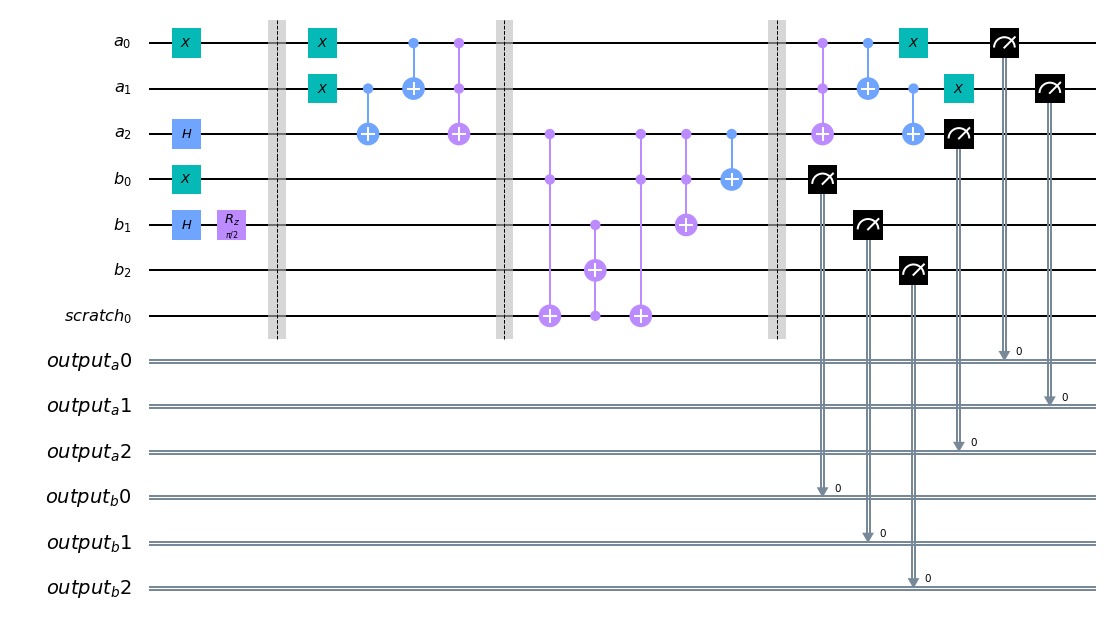

In [26]:
outputstate = result.get_statevector(qc, decimals=3)

# Fetch the counts and print out the classical measurements in order (l->R) of each q-register (a & b)       
# These counts are in reverse order as a whole and must be corrected.
counts = result.get_counts(qc)


# Rearrange the counts in the order we need them
for k in counts:
    binary_number = ''.join(reversed(k))       
  

# Debug
# print("Binary Number: ", binary_number)    
    
    
# Set up the binary numbers of each c-register (a & b) - reversing each individual register using
# the slice technique '[::-1]'.        
c_register_a = binary_number[0 : 5][::-1]
c_register_b = binary_number[6 : 11][::-1] 
    
    
# Printing classical register values for intuitions sake    
print("\n")  
print("                 Binary Positions:          4 2 1")    
print("                                            -----") 
print("Classical Register-A Measurements: (CondX) ", c_register_a)  
print("\n")
print("                 Binary Positions:  4 2 1")    
print("                                    ----") 
print("Classical Register-B Measurements: ", c_register_b)  
print("\n")

qc.draw(output='mpl')        # draw the circuit


# <font color="blue">Qiskit</font> Run # 3

- Execute the below circuit and this time observe **QISKIT's** statespace representation relative to **QCEngine's**

### QISKIT:

> ####  |<font color="red">13></font> (0.5-0j)
> ####  |<font color="red">17></font> (0.5-0j)
> ####  |<font color="red">29></font> 0.5j
> ####  |<font color="red">33></font> 0.5j

<BR>

### QCEngine:
![Conditional Execution](img/ConditionalExecution-StateSpaceSingleton.png "Conditional Execution")



<BR>

### Observe the conditional execution of only select parts of the state space:

![Conditional Execution](img/ConditionalExecution-StateSpace.png "Conditional Execution")

QISKITs QuantumState Affected Qubits 

|13> (0.5-0j)
|17> (0.5-0j)
|29> 0.5j
|33> 0.5j


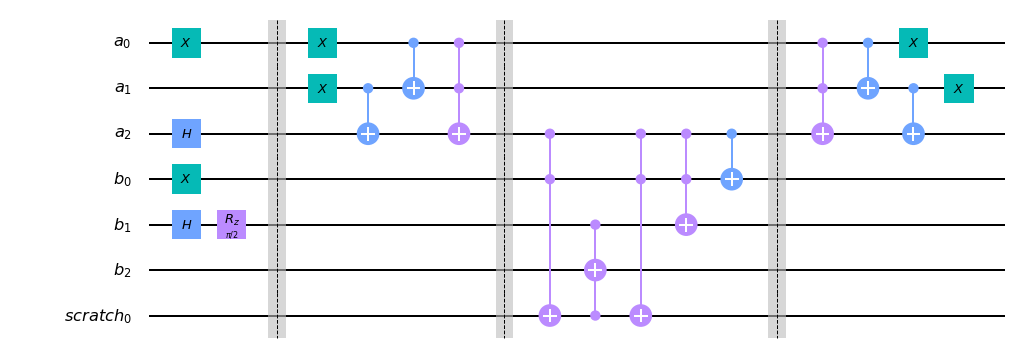

In [27]:
## Example 5-4: Quantum conditional execution

## Note that this looks different from the gates in the book, because
## we're building the operations from Toffoli gates

# Set up the program
a = QuantumRegister(3, name='a')
b = QuantumRegister(3, name='b')
scratch = QuantumRegister(1, name='scratch')
qc = QuantumCircuit(a, b, scratch)

def main():
    ## initialization
    qc.x(a[0])
    qc.h(a[2])
    qc.x(b[0])
    qc.h(b[1])
    qc.rz(math.radians(90), b[1])
    qc.barrier()
    
    ## Increment
    add_int(a, -3)
    qc.barrier()
    add_int(b, 1, [a[2]])
    qc.barrier()
    add_int(a, 3)

###############################################
## Some utility functions

def add_squared_qint(qdest, rhs, condition_qubits=None):
    if condition_qubits is None:
        condition_qubits = []
    for bit in range(len(rhs)):
        slideMask = list(set(condition_qubits + [rhs[bit]]))
        add_qint(qdest, rhs, slideMask, bit);

def add_qint(qdest, rhs, condition_qubits=None, shiftRHS=0):
    if condition_qubits is None:
        condition_qubits = []
    for bit in range(len(rhs)):
        add_int(qdest, 1 << bit, list(set([rhs[bit]] + condition_qubits)), shiftRHS)

def add_int(qdest, rhs, condition_qubits=None, shiftRHS=0):
    if condition_qubits is None:
        condition_qubits = []
    reverse_to_subtract = False
    if rhs == 0:
        return
    elif rhs < 0:
        rhs = -rhs
        reverse_to_subtract = True
    rhs <<= shiftRHS
    ops = []
    add_val = int(rhs)
    condition_mask = (1 << len(qdest)) - 1

    add_val_mask = 1
    while add_val_mask <= add_val:
        cmask = condition_mask & ~(add_val_mask - 1)
        if add_val_mask & add_val:
            add_shift_mask = 1 << (len(qdest) - 1)
            while add_shift_mask >= add_val_mask:
                cmask &= ~add_shift_mask
                ops.append((add_shift_mask, cmask))
                add_shift_mask >>= 1
        condition_mask &= ~add_val_mask
        add_val_mask <<= 1
    if reverse_to_subtract:
        ops.reverse()
    for inst in ops:
        op_qubits = [x for x in condition_qubits]
        mask = 1
        for i in range(len(qdest)):
            if inst[1] & (1 << i):
                op_qubits.append(qdest[i])
        for i in range(len(qdest)):
            if inst[0] & (1 << i):
                op_qubits.append(qdest[i])
        multi_cx(op_qubits)

def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])

main()

## That's the program. Everything below runs and draws it.

backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

outputstate = result.get_statevector(qc, decimals=3)

print("QISKITs QuantumState Affected Qubits \n")
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        print('|{}> {}'.format(i, amp))
        
        
qc.draw(output='mpl')        # draw the circuit


# <font color="red">Graded Exercises</font>  for use <font color="blue">with structured courses.</font>

#### In the previous QCEngine / Qiskit example(s), you randomly initialized a pair of quantum circuits with either a 1 or a five (and a 1 or a 3) respectively per each register (a or b). Register 'A' and 'B' could each represent 7 binary numbers.

- You then used the  **<font color="red">Conditional</font>** Operators as follows:

### **<font color="blue">Conditional Operator Behavior</font>**: 

<BR>
    
![Conditional Execution](img/conditional_execution.png "Conditional Execution")


<BR>
    
> ### Given the above as inspiration, create the following in **<font color="red">both</font> QCEngine / Qiskit** :
- Construct the circuit below modeling it closely after the code bases in **<font color="red">both</font> QCEngine / Qiskit** that you have been working with.
> - **HINTs**: 
- it only requires small modifications in the code but you'll have to follow the execution closely and understand what it does.
- Examine the circuit closely - there are only minor changes from the original code base.


<BR>


![Conditional Execution](img/QCondExec-HW.png "Conditional Execution")


<BR>

> **For Reference**:
![Conditional Execution](img/ConditionalExecution.png "Conditional Execution")

<BR>

- Use one run each **without** the **<font color="red">Conditional</font>** Operators to demonstrate the different values of the Prep-phase, as show (*for inspiration*) above. 



- **Then** use the **<font color="red">Conditional</font>** Operators to demonstrate a version of the curcuit that executes the **<font color="red">Conditional</font>** operators.



<BR>


##  <font color="blue">Your QCEngine Code Base goes below:</font>
- Use the Reads of the Measurements in the simulator to better follow the execution flow as in the examples.

##  <font color="blue">Your QISKIT Code Base goes below:</font>

### **With<font color="red">out</font>** the **<font color="red">Conditional</font>** Operator

### **<font color="red">With</font>** the **<font color="red">Conditional</font>**  Operator

##  <font color="blue">Why do we add back 3 after the circuit has completed</font>?

### Your Answer:

![the-end](img/the-end.png "the-end")